price refers to amount of money an asset can be sold in a market
short postion
long postition 


In [1]:
## install finrl library
# !sudo apt install swig
# !pip install git+https://github.com/AI4Finance-Foundation/FinRL.git

In [42]:
## We also need to install quantstats, because the environment uses it to plot graphs
# !pip install quantstats

In [1]:
## Hide matplotlib warnings
# import warnings
# warnings.filterwarnings('ignore')

import logging
logging.getLogger('matplotlib.font_manager').disabled = True

In [2]:
import torch

import numpy as np

from sklearn.preprocessing import MaxAbsScaler

from finrl.meta.preprocessor.yahoodownloader import YahooDownloader
from finrl.meta.preprocessor.preprocessors import GroupByScaler
from finrl.meta.env_portfolio_optimization.env_portfolio_optimization import PortfolioOptimizationEnv
from finrl.agents.portfolio_optimization.models import DRLAgent
from finrl.agents.portfolio_optimization.architectures import EIIE

device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

In [4]:
print(device)

cuda:0


In [3]:
TOP_DAX = [
    "SAP.DE", "SIE.DE",
    "DTE.DE", "IFX.DE", "ADS.DE"
]

In [4]:
print(len(TOP_DAX))

portfolio_raw_df = YahooDownloader(start_date = '2011-01-01',
                                end_date = '2023-12-31',
                                ticker_list = TOP_DAX).fetch_data()
portfolio_raw_df

5


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


Shape of DataFrame:  (16505, 8)


,date,open,high,low,close,volume,tic,day
0,2011-01-03,49.279999,50.070000,48.845001,41.012547,574010,ADS.DE,0
1,2011-01-03,9.744000,9.744000,9.668000,5.397497,10638603,DTE.DE,0
2,2011-01-03,7.010000,7.217000,6.997000,6.012990,7883567,IFX.DE,0
3,2011-01-03,38.154999,38.485001,37.945000,31.464462,1729328,SAP.DE,0
4,2011-01-03,81.676109,82.899063,81.344162,49.958641,2032013,SIE.DE,0
...,...,...,...,...,...,...,...,...
16500,2023-12-29,184.820007,185.360001,184.160004,183.600235,161239,ADS.DE,4
16501,2023-12-29,21.635000,21.750000,21.625000,21.008961,3172543,DTE.DE,4
16502,2023-12-29,37.740002,37.805000,37.599998,37.400299,1154724,IFX.DE,4
16503,2023-12-29,139.660004,140.199997,139.380005,137.737488,539498,SAP.DE,4


In [5]:
grouped = portfolio_raw_df.groupby('tic')

first_group_name = list(grouped.groups.keys())[0]  # Get the name of the first group
first_group = grouped.get_group(first_group_name)  # Get the first group

# Display the first 10 rows of the first group
print(first_group.head(10))

          date       open       high        low      close   volume     tic  \
0   2011-01-03  49.279999  50.070000  48.845001  41.012547   574010  ADS.DE   
5   2011-01-04  48.799999  49.235001  48.235001  40.555832   822566  ADS.DE   
10  2011-01-05  48.349998  48.470001  46.849998  39.759708  1429100  ADS.DE   
15  2011-01-06  47.735001  48.730000  47.334999  39.763905  1381177  ADS.DE   
20  2011-01-07  47.520000  48.209999  47.200001  39.847706   750859  ADS.DE   
25  2011-01-10  47.439999  47.720001  46.849998  39.608868   560470  ADS.DE   
30  2011-01-11  47.240002  48.154999  47.000000  40.266716  1029310  ADS.DE   
35  2011-01-12  47.990002  48.755001  47.865002  40.740192  1162951  ADS.DE   
40  2011-01-13  48.930000  48.959999  47.465000  39.939888   790740  ADS.DE   
45  2011-01-14  47.740002  47.740002  46.014999  39.378418  1487498  ADS.DE   

    day  
0     0  
5     1  
10    2  
15    3  
20    4  
25    0  
30    1  
35    2  
40    3  
45    4  


In [6]:
portfolio_raw_df.groupby("tic").count()

,date,open,high,low,close,volume,day
tic,,,,,,,
ADS.DE,3301,3301,3301,3301,3301,3301,3301
DTE.DE,3301,3301,3301,3301,3301,3301,3301
IFX.DE,3301,3301,3301,3301,3301,3301,3301
SAP.DE,3301,3301,3301,3301,3301,3301,3301
SIE.DE,3301,3301,3301,3301,3301,3301,3301


In [7]:
portfolio_norm_df = GroupByScaler(by="tic", scaler=MaxAbsScaler).fit_transform(portfolio_raw_df)
portfolio_norm_df

c:\Users\versu\anaconda3\envs\Thesis\lib\site-packages\finrl\meta\preprocessor\preprocessors.py:101: FutureWarning:

Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[0.04789472 0.06863394 0.11924242 ... 0.02816336 0.02699154 0.01345359]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.

c:\Users\versu\anaconda3\envs\Thesis\lib\site-packages\finrl\meta\preprocessor\preprocessors.py:101: FutureWarning:

Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[0.   0.25 0.5  ... 0.5  0.75 1.  ]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.



,date,open,high,low,close,volume,tic,day
0,2011-01-03,0.151282,0.148907,0.150339,0.125145,0.047895,ADS.DE,0.0
1,2011-01-03,0.425688,0.421362,0.425341,0.245244,0.092131,DTE.DE,0.0
2,2011-01-03,0.160467,0.164603,0.162664,0.142275,0.175932,IFX.DE,0.0
3,2011-01-03,0.257978,0.258081,0.258375,0.215026,0.077896,SAP.DE,0.0
4,2011-01-03,0.482548,0.487871,0.482812,0.302384,0.088825,SIE.DE,0.0
...,...,...,...,...,...,...,...,...
16500,2023-12-29,0.567368,0.551257,0.566821,0.560235,0.013454,ADS.DE,1.0
16501,2023-12-29,0.945173,0.940541,0.951386,0.954575,0.027474,DTE.DE,1.0
16502,2023-12-29,0.863912,0.862242,0.874114,0.884937,0.025769,IFX.DE,1.0
16503,2023-12-29,0.944287,0.940182,0.949067,0.941288,0.024301,SAP.DE,1.0


In [32]:
df_portfolio = portfolio_norm_df[["date", "tic", "close", "high", "low"]]

df_portfolio_train = df_portfolio[(df_portfolio["date"] >= "2011-01-01") & (df_portfolio["date"] < "2019-12-31")]
df_portfolio_2020 = df_portfolio[(df_portfolio["date"] >= "2020-01-01") & (df_portfolio["date"] < "2020-12-31")]
df_portfolio_2021 = df_portfolio[(df_portfolio["date"] >= "2021-01-01") & (df_portfolio["date"] < "2021-12-31")]
df_portfolio_2022 = df_portfolio[(df_portfolio["date"] >= "2022-01-01") & (df_portfolio["date"] < "2022-12-31")]
df_portfolio_2022 = df_portfolio[(df_portfolio["date"] >= "2023-01-01") & (df_portfolio["date"] < "2023-12-31")]


In [33]:
environment = PortfolioOptimizationEnv(
        df_portfolio_train,
        initial_amount=100000,
        comission_fee_pct=0.0025,
        time_window=50,
        features=["close", "high", "low"],
        normalize_df=None
    )

In [34]:
# set PolicyGradient parameters
model_kwargs = {
    "lr": 0.01,
    "policy": EIIE,
}

# here, we can set EIIE's parameters
policy_kwargs = {
    "k_size": 3,
    "time_window": 50,
}
A2C_PARAMS = {"n_steps": 10, "ent_coef": 0.005, "learning_rate": 0.0004}

model = DRLAgent(environment).get_model(model_name="pg",model_kwargs = model_kwargs)

In [35]:
DRLAgent.train_model(model, episodes=40)

  0%|          | 0/40 [00:00<?, ?it/s]

Initial portfolio value:100000
Final portfolio value: 291340.78125
Final accumulative portfolio value: 2.9134078125
Maximum DrawDown: -0.2233534764748869
Sharpe ratio: 0.821783534501081


  2%|▎         | 1/40 [00:21<13:44, 21.13s/it]

Initial portfolio value:100000
Final portfolio value: 328896.0
Final accumulative portfolio value: 3.28896
Maximum DrawDown: -0.23479730425503476
Sharpe ratio: 0.8450351000566461


  5%|▌         | 2/40 [00:42<13:31, 21.34s/it]

Initial portfolio value:100000
Final portfolio value: 481702.375
Final accumulative portfolio value: 4.81702375
Maximum DrawDown: -0.2572739405690857
Sharpe ratio: 0.9453612406910327


  8%|▊         | 3/40 [01:05<13:41, 22.21s/it]

Initial portfolio value:100000
Final portfolio value: 500057.5625
Final accumulative portfolio value: 5.000575625
Maximum DrawDown: -0.30946467598327354
Sharpe ratio: 0.8916765617732942


 10%|█         | 4/40 [01:26<13:03, 21.76s/it]

Initial portfolio value:100000
Final portfolio value: 638516.5625
Final accumulative portfolio value: 6.385165625
Maximum DrawDown: -0.34405028057988507
Sharpe ratio: 0.8885212414968577


 12%|█▎        | 5/40 [01:48<12:39, 21.70s/it]

Initial portfolio value:100000
Final portfolio value: 570186.9375
Final accumulative portfolio value: 5.701869375
Maximum DrawDown: -0.31023294106514876
Sharpe ratio: 0.8874806632754533


 15%|█▌        | 6/40 [02:09<12:12, 21.53s/it]

Initial portfolio value:100000
Final portfolio value: 649637.625
Final accumulative portfolio value: 6.49637625
Maximum DrawDown: -0.361181958351103
Sharpe ratio: 0.8920425862204981


 18%|█▊        | 7/40 [02:30<11:43, 21.33s/it]

Initial portfolio value:100000
Final portfolio value: 659712.1875
Final accumulative portfolio value: 6.597121875
Maximum DrawDown: -0.36463029295376037
Sharpe ratio: 0.8903103721715906


 20%|██        | 8/40 [02:51<11:21, 21.29s/it]

Initial portfolio value:100000
Final portfolio value: 664598.25
Final accumulative portfolio value: 6.6459825
Maximum DrawDown: -0.3632849351020181
Sharpe ratio: 0.8923199390133348


 22%|██▎       | 9/40 [03:13<10:59, 21.26s/it]

Initial portfolio value:100000
Final portfolio value: 669242.4375
Final accumulative portfolio value: 6.692424375
Maximum DrawDown: -0.3615510194666889
Sharpe ratio: 0.8946708185147662


 25%|██▌       | 10/40 [03:34<10:41, 21.38s/it]

Initial portfolio value:100000
Final portfolio value: 674295.9375
Final accumulative portfolio value: 6.742959375
Maximum DrawDown: -0.3599668839403126
Sharpe ratio: 0.8970615764425323


 28%|██▊       | 11/40 [03:55<10:19, 21.36s/it]

Initial portfolio value:100000
Final portfolio value: 679828.1875
Final accumulative portfolio value: 6.798281875
Maximum DrawDown: -0.35853393300355896
Sharpe ratio: 0.8994824073882898


 30%|███       | 12/40 [04:17<09:56, 21.32s/it]

Initial portfolio value:100000
Final portfolio value: 685834.375
Final accumulative portfolio value: 6.85834375
Maximum DrawDown: -0.3573031685597462
Sharpe ratio: 0.9019182247142037


 32%|███▎      | 13/40 [04:38<09:37, 21.38s/it]

Initial portfolio value:100000
Final portfolio value: 692332.5625
Final accumulative portfolio value: 6.923325625
Maximum DrawDown: -0.356387373426134
Sharpe ratio: 0.9043434116694189


 35%|███▌      | 14/40 [05:00<09:14, 21.34s/it]

Initial portfolio value:100000
Final portfolio value: 699404.0
Final accumulative portfolio value: 6.99404
Maximum DrawDown: -0.35603684252784085
Sharpe ratio: 0.9067143361044306


 38%|███▊      | 15/40 [05:21<08:55, 21.41s/it]

Initial portfolio value:100000
Final portfolio value: 707159.25
Final accumulative portfolio value: 7.0715925
Maximum DrawDown: -0.35654050012641736
Sharpe ratio: 0.9089923023516929


 40%|████      | 16/40 [05:42<08:30, 21.28s/it]

Initial portfolio value:100000
Final portfolio value: 715922.5
Final accumulative portfolio value: 7.159225
Maximum DrawDown: -0.3582132979019118
Sharpe ratio: 0.9112261724939704


 42%|████▎     | 17/40 [06:03<08:09, 21.26s/it]

Initial portfolio value:100000
Final portfolio value: 727074.8125
Final accumulative portfolio value: 7.270748125
Maximum DrawDown: -0.36162364942601155
Sharpe ratio: 0.9137344974144997


 45%|████▌     | 18/40 [06:25<07:48, 21.31s/it]

Initial portfolio value:100000
Final portfolio value: 757231.5625
Final accumulative portfolio value: 7.572315625
Maximum DrawDown: -0.3351434546671449
Sharpe ratio: 0.9310425915556159


 48%|████▊     | 19/40 [06:46<07:27, 21.33s/it]

Initial portfolio value:100000
Final portfolio value: 614849.1875
Final accumulative portfolio value: 6.148491875
Maximum DrawDown: -0.3236806712691592
Sharpe ratio: 0.9206482239269916


 50%|█████     | 20/40 [07:07<07:04, 21.25s/it]

Initial portfolio value:100000
Final portfolio value: 753561.75
Final accumulative portfolio value: 7.5356175
Maximum DrawDown: -0.3728585832097243
Sharpe ratio: 0.920517442271802


 52%|█████▎    | 21/40 [07:28<06:43, 21.22s/it]

Initial portfolio value:100000
Final portfolio value: 769239.8125
Final accumulative portfolio value: 7.692398125
Maximum DrawDown: -0.3772472349618109
Sharpe ratio: 0.9233519966066088


 55%|█████▌    | 22/40 [07:50<06:23, 21.29s/it]

Initial portfolio value:100000
Final portfolio value: 779860.875
Final accumulative portfolio value: 7.79860875
Maximum DrawDown: -0.3790188732707237
Sharpe ratio: 0.9262667108068616


 57%|█████▊    | 23/40 [08:12<06:06, 21.54s/it]

Initial portfolio value:100000
Final portfolio value: 790329.4375
Final accumulative portfolio value: 7.903294375
Maximum DrawDown: -0.3803518095327292
Sharpe ratio: 0.9292734423432752


 60%|██████    | 24/40 [08:36<05:58, 22.43s/it]

Initial portfolio value:100000
Final portfolio value: 798655.0625
Final accumulative portfolio value: 7.986550625
Maximum DrawDown: -0.3785017998669803
Sharpe ratio: 0.931946990980115


 62%|██████▎   | 25/40 [09:02<05:52, 23.52s/it]

Initial portfolio value:100000
Final portfolio value: 787133.4375
Final accumulative portfolio value: 7.871334375
Maximum DrawDown: -0.3612423686279288
Sharpe ratio: 0.932993145150567


 65%|██████▌   | 26/40 [09:31<05:51, 25.12s/it]

Initial portfolio value:100000
Final portfolio value: 789684.0
Final accumulative portfolio value: 7.89684
Maximum DrawDown: -0.36212405304010364
Sharpe ratio: 0.9346441418818037


 68%|██████▊   | 27/40 [09:58<05:34, 25.72s/it]

Initial portfolio value:100000
Final portfolio value: 794739.3125
Final accumulative portfolio value: 7.947393125
Maximum DrawDown: -0.36440750613597994
Sharpe ratio: 0.9354212288059535


 70%|███████   | 28/40 [10:23<05:04, 25.39s/it]

Initial portfolio value:100000
Final portfolio value: 799174.4375
Final accumulative portfolio value: 7.991744375
Maximum DrawDown: -0.3657602139633084
Sharpe ratio: 0.9361618303813258


 72%|███████▎  | 29/40 [10:46<04:29, 24.54s/it]

Initial portfolio value:100000
Final portfolio value: 803107.8125
Final accumulative portfolio value: 8.031078125
Maximum DrawDown: -0.3663715035211438
Sharpe ratio: 0.9369990628661957


 75%|███████▌  | 30/40 [11:08<03:57, 23.78s/it]

Initial portfolio value:100000
Final portfolio value: 806853.9375
Final accumulative portfolio value: 8.068539375
Maximum DrawDown: -0.3664259578682971
Sharpe ratio: 0.9380044852381056


 78%|███████▊  | 31/40 [11:32<03:34, 23.83s/it]

Initial portfolio value:100000
Final portfolio value: 810739.8125
Final accumulative portfolio value: 8.107398125
Maximum DrawDown: -0.3660307167849497
Sharpe ratio: 0.9393032283884852


 80%|████████  | 32/40 [11:55<03:10, 23.78s/it]

Initial portfolio value:100000
Final portfolio value: 815029.0
Final accumulative portfolio value: 8.15029
Maximum DrawDown: -0.3652812595226146
Sharpe ratio: 0.9410039309988901


 82%|████████▎ | 33/40 [12:19<02:46, 23.74s/it]

Initial portfolio value:100000
Final portfolio value: 819887.25
Final accumulative portfolio value: 8.1988725
Maximum DrawDown: -0.36469280182526
Sharpe ratio: 0.9431459984199267


 85%|████████▌ | 34/40 [12:41<02:19, 23.33s/it]

Initial portfolio value:100000
Final portfolio value: 824778.125
Final accumulative portfolio value: 8.24778125
Maximum DrawDown: -0.36405008086265367
Sharpe ratio: 0.9453357319278283


 88%|████████▊ | 35/40 [13:02<01:53, 22.70s/it]

Initial portfolio value:100000
Final portfolio value: 828701.8125
Final accumulative portfolio value: 8.287018125
Maximum DrawDown: -0.36416368712689995
Sharpe ratio: 0.9468540756977794


 90%|█████████ | 36/40 [13:24<01:29, 22.27s/it]

Initial portfolio value:100000
Final portfolio value: 831690.6875
Final accumulative portfolio value: 8.316906875
Maximum DrawDown: -0.36515676006383646
Sharpe ratio: 0.9476666639215007


 92%|█████████▎| 37/40 [13:45<01:05, 21.95s/it]

Initial portfolio value:100000
Final portfolio value: 834205.25
Final accumulative portfolio value: 8.3420525
Maximum DrawDown: -0.3664087729367542
Sharpe ratio: 0.9481739163162198


 95%|█████████▌| 38/40 [14:06<00:43, 21.71s/it]

Initial portfolio value:100000
Final portfolio value: 836464.5625
Final accumulative portfolio value: 8.364645625
Maximum DrawDown: -0.36761268699315897
Sharpe ratio: 0.9485923801794611


 98%|█████████▊| 39/40 [14:28<00:21, 21.88s/it]

Initial portfolio value:100000
Final portfolio value: 838496.6875
Final accumulative portfolio value: 8.384966875
Maximum DrawDown: -0.36884588622891856
Sharpe ratio: 0.9489241202507706


100%|██████████| 40/40 [14:50<00:00, 22.25s/it]


In [36]:
torch.save(model.train_policy.state_dict(), "policy_EIIE.pt")

In [37]:
environment_2020 = PortfolioOptimizationEnv(
    df_portfolio_2020,
    initial_amount=100000,
    comission_fee_pct=0.0025,
    time_window=50,
    features=["close", "high", "low"],
    normalize_df=None
)

environment_2021 = PortfolioOptimizationEnv(
    df_portfolio_2021,
    initial_amount=100000,
    comission_fee_pct=0.0025,
    time_window=50,
    features=["close", "high", "low"],
    normalize_df=None
)

environment_2022 = PortfolioOptimizationEnv(
    df_portfolio_2022,
    initial_amount=100000,
    comission_fee_pct=0.0025,
    time_window=50,
    features=["close", "high", "low"],
    normalize_df=None
)

In [40]:
EIIE_results = {
    "training": environment._asset_memory["final"],
    "2020": {},
    "2021": {},
    "2022": {}
}

# instantiate an architecture with the same arguments used in training
# and load with load_state_dict.
policy = EIIE(time_window=50, device=device)
policy.load_state_dict(torch.load("policy_EIIE.pt"))

# 2020
DRLAgent.DRL_validation(model, environment_2022, policy=policy)
EIIE_results["2020"]["value"] = environment_2020._asset_memory["final"]


RuntimeError: Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTensor) should be the same

In [31]:
UBAH_results = {
    "train": {},
    "2020": {},
    "2021": {},
    "2022": {}
}

PORTFOLIO_SIZE = len(TOP_DAX)

# train period
terminated = False
environment.reset()
while not terminated:
    action = [0] + [1/PORTFOLIO_SIZE] * PORTFOLIO_SIZE
    _, _, terminated, _ = environment.step(action)
UBAH_results["train"]["value"] = environment._asset_memory["final"]

# 2020
terminated = False
environment_2020.reset()
while not terminated:
    action = [0] + [1/PORTFOLIO_SIZE] * PORTFOLIO_SIZE
    _, _, terminated, _ = environment_2020.step(action)
UBAH_results["2020"]["value"] = environment_2020._asset_memory["final"]

# 2021
terminated = False
environment_2021.reset()
while not terminated:
    action = [0] + [1/PORTFOLIO_SIZE] * PORTFOLIO_SIZE
    _, _, terminated, _ = environment_2021.step(action)
UBAH_results["2021"]["value"] = environment_2021._asset_memory["final"]

# 2022
terminated = False
environment_2022.reset()
while not terminated:
    action = [0] + [1/PORTFOLIO_SIZE] * PORTFOLIO_SIZE
    _, _, terminated, _ = environment_2022.step(action)
UBAH_results["2022"]["value"] = environment_2022._asset_memory["final"]

Initial portfolio value:100000
Final portfolio value: 337879.875
Final accumulative portfolio value: 3.37879875
Maximum DrawDown: -0.25850971899744835
Sharpe ratio: 0.8201383817062785
Initial portfolio value:100000
Final portfolio value: 145457.859375
Final accumulative portfolio value: 1.45457859375
Maximum DrawDown: -0.204808828125
Sharpe ratio: 1.4629131239179554
Initial portfolio value:100000
Final portfolio value: 108887.6875
Final accumulative portfolio value: 1.088876875
Maximum DrawDown: -0.08785486814003207
Sharpe ratio: 0.6711344315201969
Initial portfolio value:100000
Final portfolio value: 116504.1328125
Final accumulative portfolio value: 1.165041328125
Maximum DrawDown: -0.12174862163991873
Sharpe ratio: 1.1865898894008025


### Plot graphics

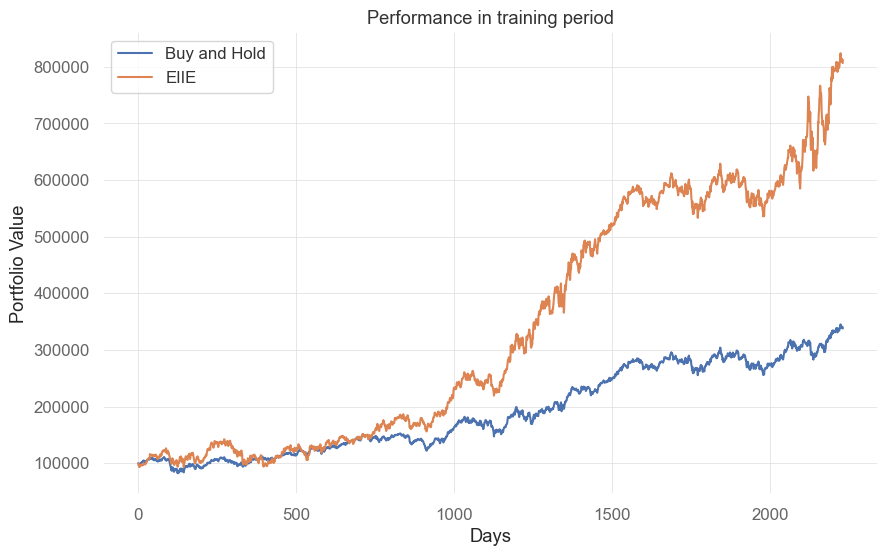

In [66]:
import matplotlib.pyplot as plt
%matplotlib inline 

plt.plot(UBAH_results["train"]["value"], label="Buy and Hold")
plt.plot(EIIE_results["training"], label="EIIE")

plt.xlabel("Days")
plt.ylabel("Portfolio Value")
plt.title("Performance in training period")
plt.legend()

plt.show()

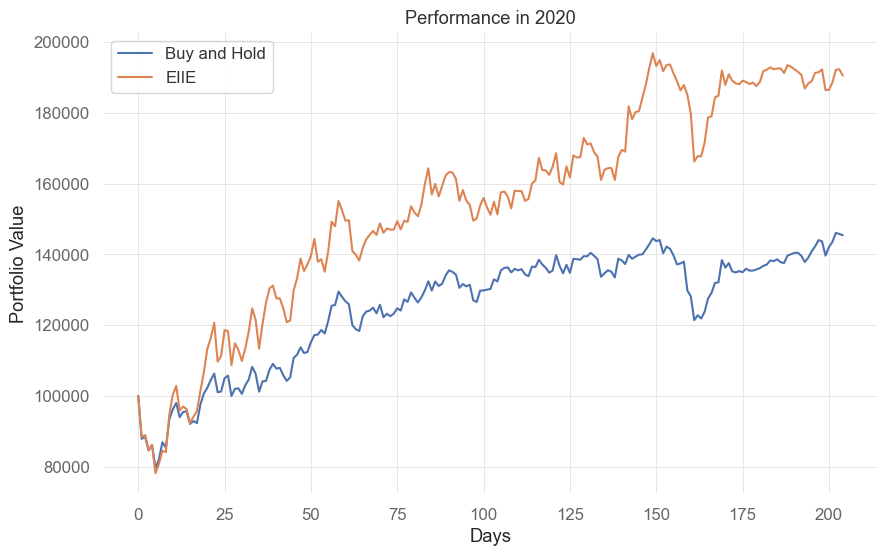

In [67]:
plt.plot(UBAH_results["2020"]["value"], label="Buy and Hold")
plt.plot(EIIE_results["2020"]["value"], label="EIIE")

plt.xlabel("Days")
plt.ylabel("Portfolio Value")
plt.title("Performance in 2020")
plt.legend()

plt.show()

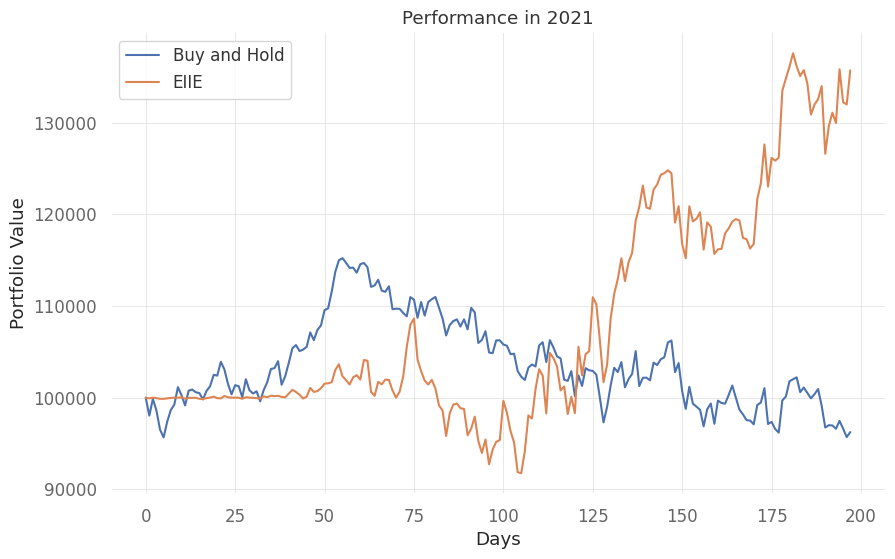

In [59]:
plt.plot(UBAH_results["2021"]["value"], label="Buy and Hold")
plt.plot(EIIE_results["2021"]["value"], label="EIIE")

plt.xlabel("Days")
plt.ylabel("Portfolio Value")
plt.title("Performance in 2021")
plt.legend()

plt.show()

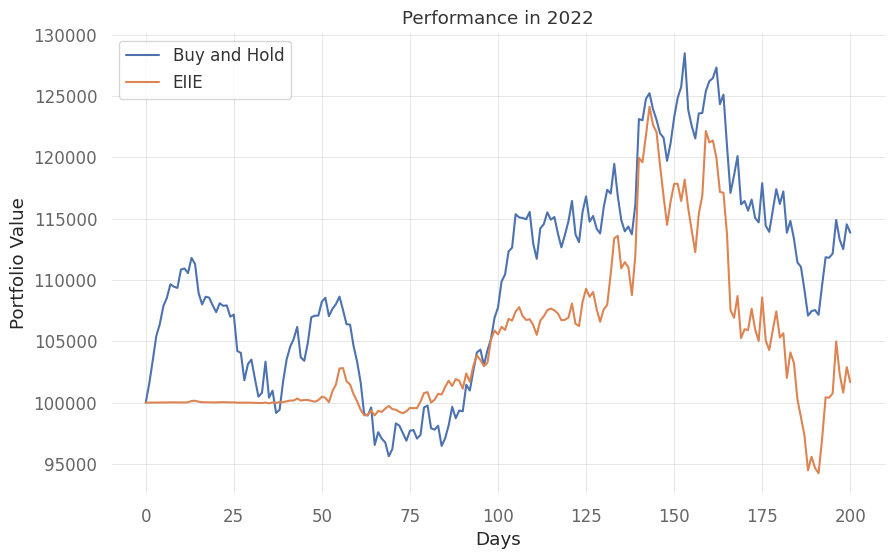

In [60]:
plt.plot(UBAH_results["2022"]["value"], label="Buy and Hold")
plt.plot(EIIE_results["2022"]["value"], label="EIIE")

plt.xlabel("Days")
plt.ylabel("Portfolio Value")
plt.title("Performance in 2022")
plt.legend()

plt.show()